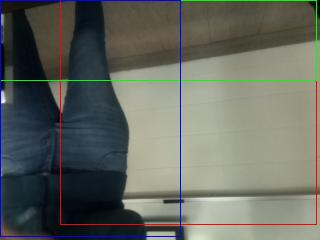

In [ ]:
print( "start" )

import time
import picamera
import numpy as np
import threading
import queue
import io
import IPython
import cv2 as cv
from PIL import Image
from sklearn.cluster import KMeans

body_cascade = cv.CascadeClassifier('haarcascade_upperbody.xml')
face_cascade = cv.CascadeClassifier('haarcascade_frontalface_alt.xml')
eye_cascade = cv.CascadeClassifier('haarcascade_eye.xml')

# Use 'jpeg' instead of 'png' (~5 times faster)
def showarray( a, fmt='jpeg', width = 480, height = 360 ):
    '''
    Function to display an image within a Jupyter notebook.
    '''
    f = io.BytesIO()
    Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue(), width = width, height = height))

def resizeNPArray(array, width, height):
    '''
    Function to resize a given numpy array to another width/height,
    whilst preserving the relative information - used for images.
    '''
    img = Image.fromarray(array)
    img = img.resize((width, height), Image.ANTIALIAS)
    resized = np.asarray(img)
    return resized

def detectBodyAndFaceAndEyes(img_array):
    '''
    Function to detect eyes and faces using a Haar-Cascade classifier.
    '''
    roi_gray_face = roi_gray = gray = cv.cvtColor(img_array, cv.COLOR_BGR2GRAY)
    roi_color_face = roi_color = img_array
    body = body_cascade.detectMultiScale(gray,scaleFactor = 1.01,minNeighbors = 5,flags = cv.CASCADE_SCALE_IMAGE)
    for (x,y,w,h) in body:
        cv.rectangle(img_array,(x,y),(x+w,y+h),(0,128,255),2)
        roi_gray_face = roi_gray = gray[y:y+h, x:x+w]
        roi_color_face = roi_color = img_array[y:y+h, x:x+w]
        faces = face_cascade.detectMultiScale(roi_gray)
        for (fx,fy,fw,fh) in faces:
            cv.rectangle(roi_color,(fx,fy),(fx+fw,fy+fh),(128,255,0),2)
            roi_gray_face = roi_gray[y:y+h, x:x+w]
            roi_color_face = roi_color[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray_face)
            for (ex,ey,ew,eh) in eyes:
                cv.rectangle(roi_color_face,(ex,ey),(ex+ew,ey+eh),(255,0,128),2)

class ImageProcessor(threading.Thread):
    '''
    Thread-safe class to process a stream of jpeg sequences from a given queue.
    '''
    def __init__(self, thread_stopper, frames, lock):
        '''
        thread_stopper -> Is the event which stops the thread when set.
        frames -> The queue from which jpeg images come (in numpy.array format).
        lock -> Mutex for the queue.
        '''
        super().__init__()
        self.thread_stopper = thread_stopper
        self.frames = frames
        self.lock = lock
        self.incoming = np.empty((240, 320, 3), dtype = np.uint8)
#         self.processed = np.zeros((240, 320, 3), dtype = np.uint8)
        
        self.verticals = np.array(80 * [np.arange(0, 60)]).T
        self.verticals = self.verticals[:,:,np.newaxis]
        
        self.horizontals = np.array(60 * [np.arange(0, 80)])
        self.horizontals = self.horizontals[:,:,np.newaxis]
        
    def run(self):
        '''
        Main thread which runs indefinitely until <<thread_stopper>> event is set.
        This function processes each incoming image from the queue iteratively and then displays it in this notebook.
        '''
        print("image processing thread starting")
        while not thread_stopper.is_set():
            try:
                self.lock.acquire()
                self.incoming = self.frames.get_nowait()
#                 self.position, self.processed = self.dowork( self.incoming )
                self.dowork( self.incoming )
                self.frames.task_done()
            except queue.Empty:
                continue
            finally:
                self.lock.release()
#             showarray(self.processed)
            showarray(self.incoming)
            IPython.display.clear_output(wait = True)
        print("image processing thread stopping")
            
    def dowork( self, array ):
        '''
        array -> Is a numpy array that holds the a RGB image.
        Function to process an image and detect spots of a given targeted color.
        '''
        
        detectBodyAndFaceAndEyes(array)
        self.detectColorArea( array, [255,   0,   0], [255,   0,   0] )
        self.detectColorArea( array, [  0, 255,   0], [  0, 255,   0] )
        self.detectColorArea( array, [  0,   0, 255], [  0,   0, 255] )

    def detectColorArea( self, array, target_color, border_color ):
        # down-sizing the image and running KMeans on it
#         output = array.copy()
        output = array
        array = resizeNPArray(array, 80, 60)
        image_and_positions = np.concatenate((array, self.verticals, self.horizontals), axis = 2)
        reshaped = image_and_positions.reshape((60 * 80, 5))
        kmeans = KMeans(n_clusters = 6,
                       n_init = 1,
                       max_iter = 300,
                       precompute_distances = True).fit(reshaped)
        rgb_centers = kmeans.cluster_centers_[:, 0:3]

        labels_rgb = np.empty((4800, 3))
        for i in range(6):
            labels_rgb[kmeans.labels_ == i] = rgb_centers[i]
        labels_rgb = labels_rgb.reshape((60, 80, 3)).astype(np.uint8)

        # getting the closest KMeans center to the targeted color
        diff = rgb_centers - target_color
        closest = np.sqrt(np.power(diff, 2).sum(axis = 1))
        closest_label = closest.argmin()

        # determining the distribution of the targeted pixels
        # (the target pixels are identified with the label of the selected KMeans center)
        labels = kmeans.labels_.reshape((60, 80))
        labels = labels == closest_label
        sum_labels_vertical = labels.sum(axis = 1)
        sum_labels_horizontal = labels.sum(axis = 0)

        # 4800 = 60 * 80 pixels
        if not sum_labels_vertical.sum() > color_threshold * 4800:
            return (None, output)

        # find the countour of the spot of color
        non_zero_elements = np.nonzero(sum_labels_vertical)
        # multiply by 4 to get to the original size
        min_vertical = np.min(non_zero_elements) * 4
        max_vertical = np.max(non_zero_elements) * 4
        non_zero_elements = np.nonzero(sum_labels_horizontal)
        min_horizontal = np.min(non_zero_elements) * 4
        max_horizontal = np.max(non_zero_elements) * 4

        # and then draw a rectangle around the detected spot of color
        output[min_vertical:max_vertical+1,min_horizontal,:] = border_color
        output[min_vertical:max_vertical+1,max_horizontal,:] = border_color
        output[min_vertical,min_horizontal:max_horizontal+1,:] = border_color
        output[max_vertical,min_horizontal:max_horizontal+1,:] = border_color

        center_position = (min_vertical + max_vertical) / 2

        return (center_position, output)

frames = queue.Queue(maxsize = 10)
thread_stopper = threading.Event()
lock = threading.Lock()
default_target_color = np.array([255, 255, 255]) # white
default_border_color = np.array([0, 255, 0]) # green
color_threshold = 0.07 # in percentage
time_to_run = 300 # in seconds

start = time.time()
imageThread = ImageProcessor(thread_stopper, frames, lock)
imageThread.start()

print("starting picamera session")
with picamera.PiCamera() as camera:
    camera.resolution = (320, 240)
    camera.framerate = 5
    while time.time() - start < time_to_run:
        freshest_frame = np.empty((240, 320, 3), dtype = np.uint8)
        camera.capture_sequence([freshest_frame], use_video_port = True, format = 'rgb')
        lock.acquire()
        if frames.full():
            frames.get()
            frames.task_done()
        else:
            frames.put(freshest_frame)
        lock.release()
print("picamera session ended")

thread_stopper.set()
print("triggered image processing thread stop")

imageThread.join()
print("thread joined")